## Day Type Identification of Algerian Electricity Load

**Introduction:**

This Jupyter notebook explores the identification of different day types based on electricity load patterns in an Algerian city. We will analyze a dataset containing hourly recordings of Maximum Power Demand (PMA) and Temperature for two years, from January 1st, 2016, to December 31st, 2017.

**Data Source:**

The dataset used in this analysis is stored in a file named `pma.xlsx`. It contains three columns:

* `time`: Date and time (hourly)
* `pma`: Maximum Power Demand (MW)
* `tmp`: Temperature (°C)

**Software and Tools:**

This project will utilize Python libraries such as:

* `pandas` for data manipulation and analysis
* `numpy` for scientific computing
* `matplotlib` and `seaborn` for data visualization
* `scikit-learn` for machine learning and clustering algorithms

**Let's begin by importing the necessary libraries and reading the data into a Pandas dataframe.**


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

In [64]:
# Load the data
df = pd.read_excel("pma.xlsx", skiprows=1)

# Rename columns
df.columns = ["time", "pma", "tmp"]

# Convert time column to datetime
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
# # Create a column for date only without time
# df['date'] = df['time'].dt.date
# # Create a column for year
# df['year'] = df.time.dt.year
# # Create a column for month of the year
# df['month'] = df.time.dt.month
# # Create a column for day of the month
# df['day'] = df.time.dt.day
# # Create a column for day names of the week
# df['dayName'] = df['time'].dt.day_name()
# # Create a column for hour of the day
# df['hour'] = df['time'].dt.hour
# # Drop time column
df.drop('time', axis=1)

df.head()



,time,pma,tmp,date,year,month,day,dayName,hour
0,2016-01-01 01:00:00,982.529002,6.405644,2016-01-01,2016,1,1,Friday,1
1,2016-01-01 02:00:00,983.240592,5.932445,2016-01-01,2016,1,1,Friday,2
2,2016-01-01 03:00:00,1002.780354,5.503807,2016-01-01,2016,1,1,Friday,3
3,2016-01-01 04:00:00,1011.657004,5.112056,2016-01-01,2016,1,1,Friday,4
4,2016-01-01 05:00:00,999.137230,4.751342,2016-01-01,2016,1,1,Friday,5


## Exploratory Data Analysis (EDA)

#### shape of the data

In [65]:
print(f'number of rows: {df.shape[0]}')
print(f'number of columns: {df.shape[1]}')

number of rows: 17543
number of columns: 9


#### description

In [66]:
df.describe()

,time,pma,tmp,year,month,day,hour
count,17543,17543.000000,17543.000000,17543.000000,17543.000000,17543.000000,17543.000000
mean,2016-12-31 12:00:00,1270.604817,17.971414,2016.499344,6.520150,15.739554,11.500656
min,2016-01-01 01:00:00,558.397028,-1.377706,2016.000000,1.000000,1.000000,0.000000
25%,2016-07-01 18:30:00,1091.574864,10.856301,2016.000000,4.000000,8.000000,6.000000
50%,2016-12-31 12:00:00,1252.618854,17.281236,2016.000000,7.000000,16.000000,12.000000
75%,2017-07-02 05:30:00,1429.612106,24.250000,2017.000000,10.000000,23.000000,17.500000
max,2017-12-31 23:00:00,2174.951321,42.500000,2017.000000,12.000000,31.000000,23.000000
std,NaN,256.452804,8.773186,0.500014,3.449496,8.803719,6.922037


#### missing data

In [67]:
total_missing_values = df.isna().sum().sum()
print(f'total of missing values: {total_missing_values}')

total of missing values: 0


#### duplicates

In [68]:
total_duplicates = df.duplicated().sum()
print(f'total of missing values: {total_duplicates}')

total of missing values: 0


### Trends

#### PMA over all time

Here, we will try to see the development of the maximum power demand over time in 2016 and 2017 by months

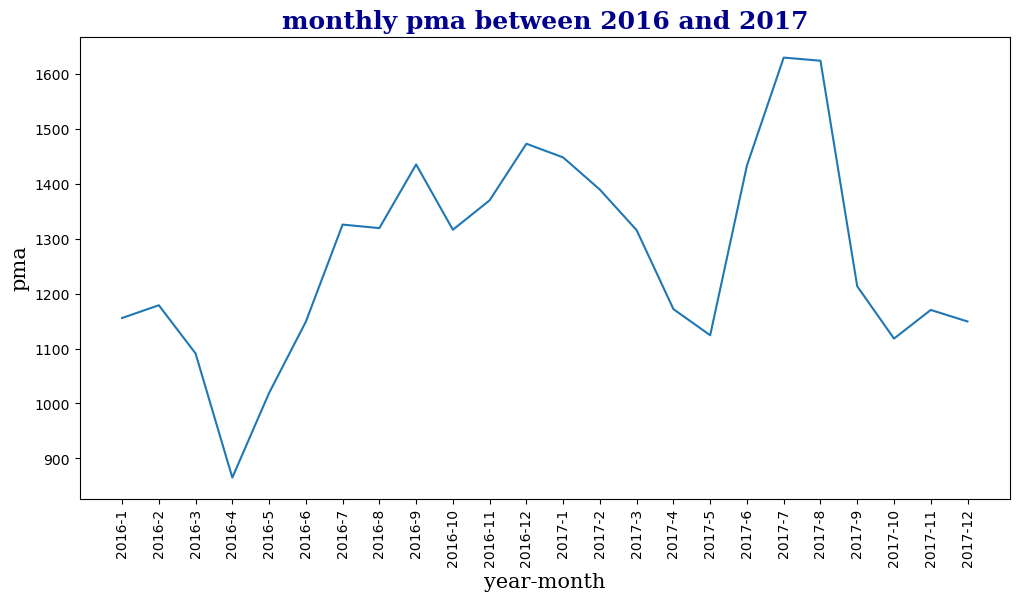

In [69]:
# group
year_month_grouped_pma = df.groupby(['year', 'month']).pma.agg(years_monthly_pma='mean')

title_style = {'family':'serif','color':'darkblue','size':18, 'weight':'bold'}
labels_style = {'family':'serif','color':'black','size':15}
def line_plot(data, x, y, title='', xlabel='', ylabel='', rotate_x=0):
    plt.figure(figsize=[12, 6])
    plt.title(title, fontdict=title_style)
    plt.ylabel(ylabel, fontdict=labels_style)
    plt.xlabel(xlabel, fontdict=labels_style)
    plt.xticks(rotation=rotate_x)
    sns.lineplot(data=data, x=x, y=y)
    plt.show()

# adding a column for the combination year-month
year_month_grouped_pma['year_month'] = year_month_grouped_pma.index.map(lambda x: f'{x[0]}' + '-' + f'{x[1]}')
# year_month_grouped_pma

# plotting the data
line_plot(year_month_grouped_pma, 'year_month', 'years_monthly_pma', 'monthly pma between 2016 and 2017', 'year-month', 'pma', 90)

As we notice, for now, maximum power demand increases mostly during summer from May till October.  
To see this better, let us take the average pma between the two years for ech month:

#### PMA over months

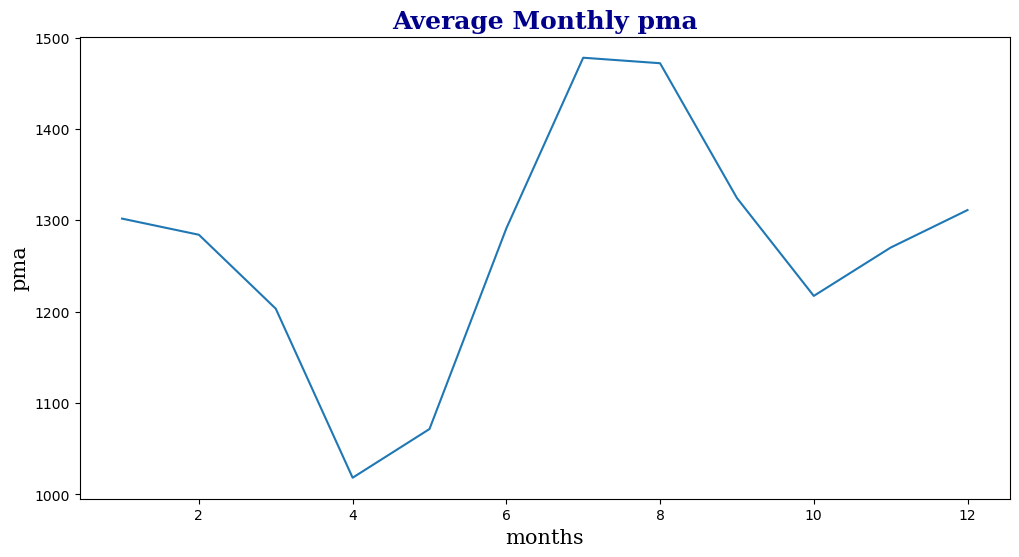

In [70]:
year_month_grouped_pma
monthly_grouped_pma = year_month_grouped_pma.groupby('month').years_monthly_pma.agg(average_monthly_pma='mean')
# monthly_grouped_pma
line_plot(monthly_grouped_pma, 'month', 'average_monthly_pma', 'Average Monthly pma', 'months', 'pma')

Great, It is clear enough now.

#### PMA over days

Now, let us find the hours of the day with most power demand.

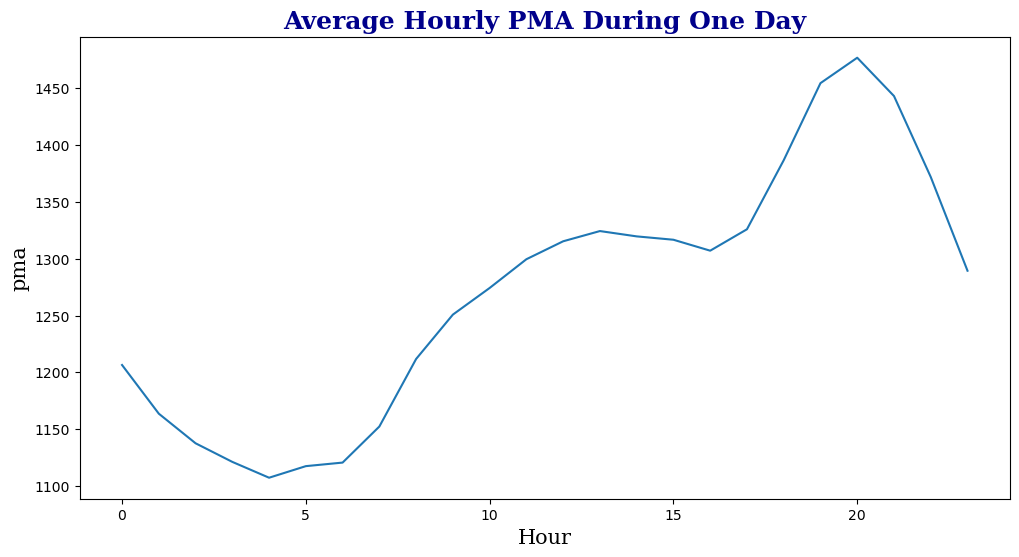

In [71]:
hourly_grouped_pma = df.groupby('hour').pma.agg(hourly_pma='mean')
#hourly_grouped_pma
line_plot(hourly_grouped_pma, 'hour', 'hourly_pma', 'Average Hourly PMA During One Day', 'Hour', 'pma')

However, this one is for both two years, let us do it for each season and try to compare.

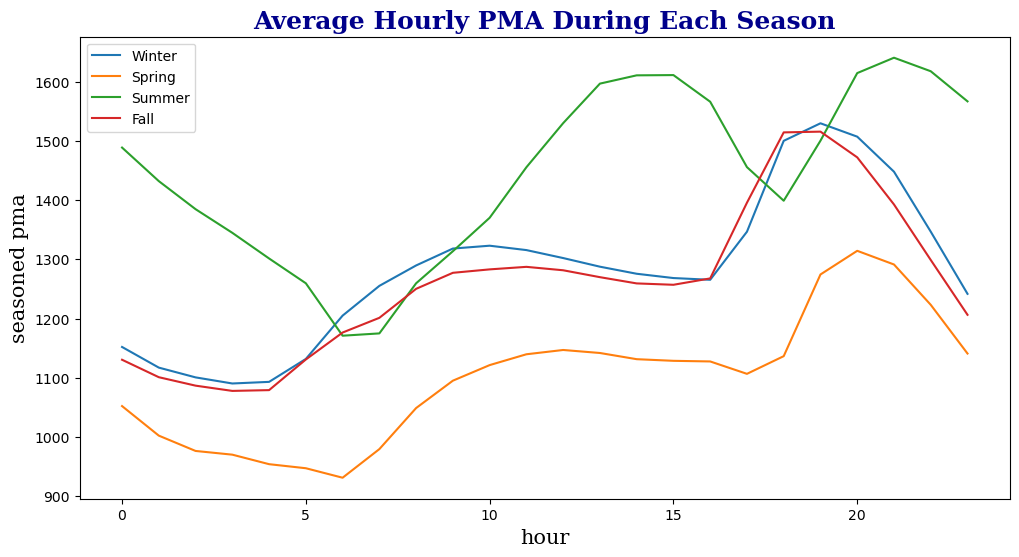

In [73]:
seasoned_hourly_grouped_pma = df.groupby(['season', 'hour']).pma.agg(seasoned_hourly_pma='mean')
fall_hourly = seasoned_hourly_grouped_pma[seasoned_hourly_grouped_pma.index.get_level_values('season')=='Fall']
winter_hourly = seasoned_hourly_grouped_pma[seasoned_hourly_grouped_pma.index.get_level_values('season')=='Winter']
spring_hourly = seasoned_hourly_grouped_pma[seasoned_hourly_grouped_pma.index.get_level_values('season')=='Spring']
summer_hourly = seasoned_hourly_grouped_pma[seasoned_hourly_grouped_pma.index.get_level_values('season')=='Summer']

plt.figure(figsize=[12, 6])
plt.title('Average Hourly PMA During Each Season', fontdict=title_style)
plt.ylabel('seasoned pma', fontdict=labels_style)
plt.xlabel('hour', fontdict=labels_style)

for season in seasons:
    seasoned_hourly = seasoned_hourly_grouped_pma[seasoned_hourly_grouped_pma.index.get_level_values('season')==season]
    #line_plot(seasoned_hourly, 'hour', 'seasoned_hourly_pma', f'Average Hourly Demand in {season}', 'Hour', 'pma')
    sns.lineplot(data=seasoned_hourly, x='hour', y='seasoned_hourly_pma', label=season)

plt.show()

#### PMA in Week Days

We'll now discover which day in the week has the highest consumption of energy

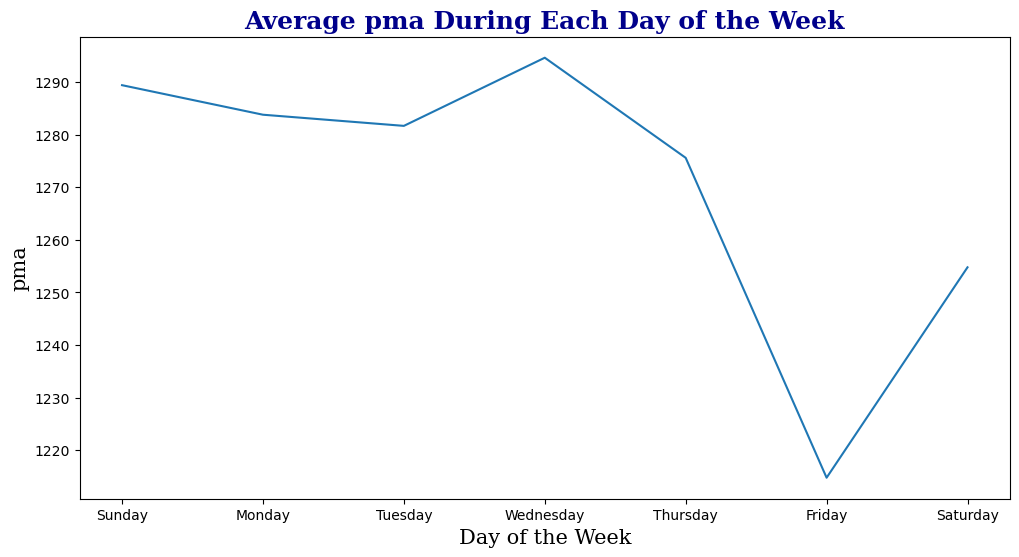

In [74]:
# We plot the average usage of each day of the week
dayName_grouped_pma = df.groupby('dayName').pma.agg(average_pma='mean')

# We sort the days of the week
dayName_grouped_pma = dayName_grouped_pma.reindex(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

# We plot the data
line_plot(dayName_grouped_pma, 'dayName', 'average_pma', 'Average pma During Each Day of the Week', 'Day of the Week', 'pma')


> We notice that the consumption is low in the weekends because most of people rest or go for picnics

#### PMA in special days (Eids Days)

Let us discover how was the usage of people in "Eids", we might find some high usage due to family gathering



In [75]:
# We first define the special days (Eids in 2016 and 2017)
special_days = ['2016-07-06', '2017-06-25', '2016-09-12', '2017-09-01']
special_days = pd.to_datetime(special_days).date
special_days_df = df[df['date'].isin(special_days)]
special_days_df

,time,pma,tmp,date,year,month,day,dayName,hour,season
4487,2016-07-06 00:00:00,1538.428850,23.713276,2016-07-06,2016,7,6,Wednesday,0,Summer
4488,2016-07-06 01:00:00,1462.136981,22.833816,2016-07-06,2016,7,6,Wednesday,1,Summer
4489,2016-07-06 02:00:00,1406.681766,22.077255,2016-07-06,2016,7,6,Wednesday,2,Summer
4490,2016-07-06 03:00:00,1324.151848,21.413419,2016-07-06,2016,7,6,Wednesday,3,Summer
4491,2016-07-06 04:00:00,1307.678685,20.822039,2016-07-06,2016,7,6,Wednesday,4,Summer
...,...,...,...,...,...,...,...,...,...,...
14634,2017-09-01 19:00:00,1708.430359,31.203801,2017-09-01,2017,9,1,Friday,19,Summer
14635,2017-09-01 20:00:00,1806.951276,29.043954,2017-09-01,2017,9,1,Friday,20,Summer
14636,2017-09-01 21:00:00,1852.200849,27.618178,2017-09-01,2017,9,1,Friday,21,Summer
14637,2017-09-01 22:00:00,1852.539318,26.552136,2017-09-01,2017,9,1,Friday,22,Summer


Let's compare the usage in Eid days to the overall usage

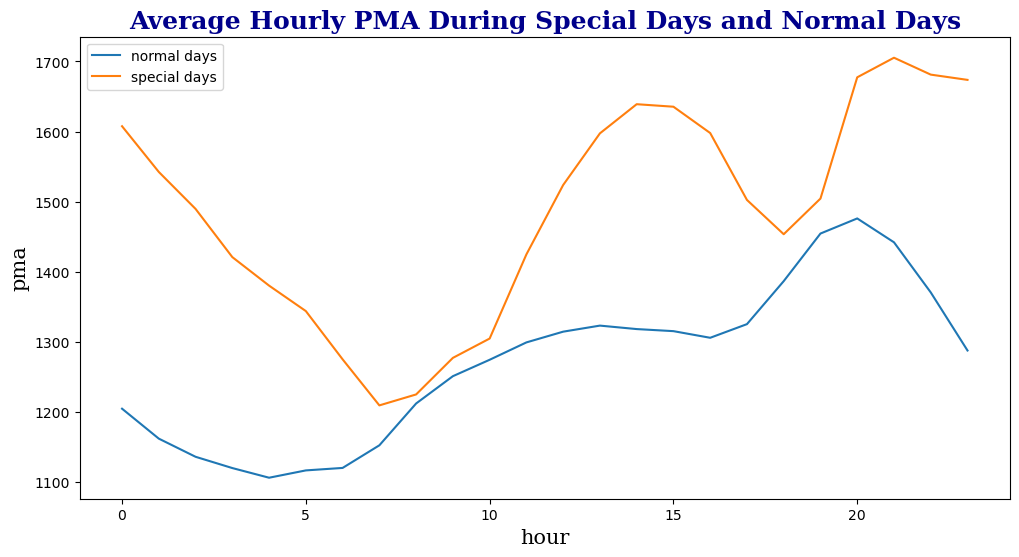

In [76]:
# We plot a comparison between the average hourly pma in the special days and the average hourly pma in the normal days
normal_days_df = df[~df['date'].isin(special_days)]
normal_days_hourly_grouped_pma = normal_days_df.groupby('hour').pma.agg(normal_hourly_pma='mean')
special_days_hourly_grouped_pma = special_days_df.groupby('hour').pma.agg(special_hourly_pma='mean')
# we plot the comparison
plt.figure(figsize=[12, 6])
plt.title('Average Hourly PMA During Special Days and Normal Days', fontdict=title_style)
plt.ylabel('pma', fontdict=labels_style)
plt.xlabel('hour', fontdict=labels_style)
sns.lineplot(data=normal_days_hourly_grouped_pma, x='hour', y='normal_hourly_pma', label='normal days')
sns.lineplot(data=special_days_hourly_grouped_pma, x='hour', y='special_hourly_pma', label='special days')
plt.show()


> It's remarkable that the usage in Eids is higher than in the normal days due to family gathering and especially that Eids were in the summer

#### Key notes

* Power demand reaches its maximum values during summer. Which logical, most people are in holidays thus staying at home most of the time compared to the rest of the year.
* During one day, PMA reaches its climax at around 8pm.
* During Winter, max demand is at its peak before 8pm, and after that time it starts decreasing. This could be due to many reasons. One of them is that people tend to sleep earlier at winter. Meanwhile during summer, it reaches its climax after 8pm and higher values as well 1pm and 4pm. Because, most people are at their homes with their AC (Air Conditioner) on at those times due to high temperatures outside.
* Demand is low in all seasons during night (most logically) and medium during day where everyone are doing their activities and daily tasks.
* Demand is low in weekends which is also logic because people are resting and companies are off
* Demand is higher in Eids because of family gathering which cause a high consumption of electricity (lights on everywhere, hair dryer for women..etc)

### Relationships

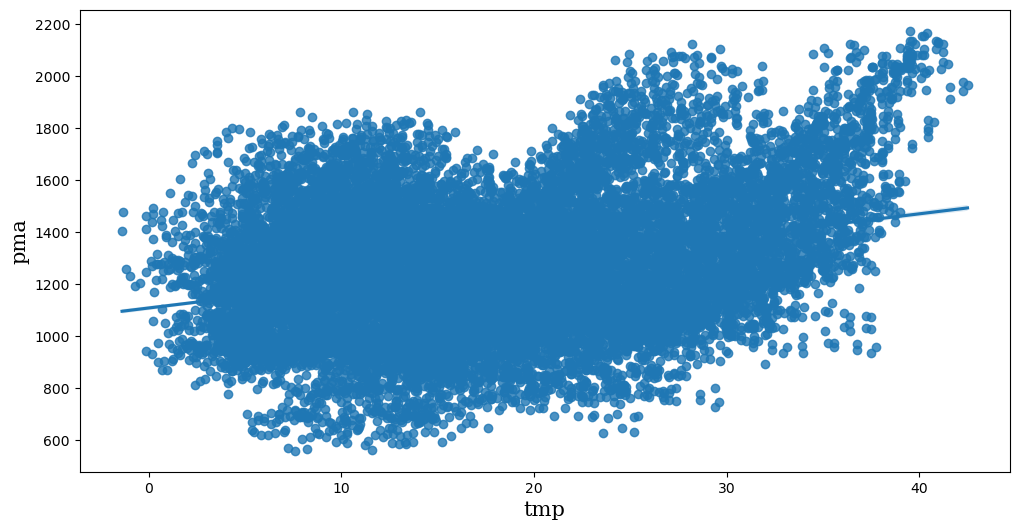

In [77]:
#df
def scatter_plot(data, x, y, title='', xlabel='', ylabel='', rotate_x=0):
    title_style = {'family':'serif','color':'darkblue','size':18, 'weight':'bold'}
    labels_style = {'family':'serif','color':'black','size':15}
    plt.figure(figsize=[12, 6])
    plt.title(title, fontdict=title_style)
    plt.ylabel(ylabel, fontdict=labels_style)
    plt.xlabel(xlabel, fontdict=labels_style)
    plt.xticks(rotation=rotate_x)
    sns.regplot(data=data, x=x, y=y)
    plt.show()
scatter_plot(df, 'tmp', 'pma')

# Setting up the dataframe for clustering

## Day, Month, Special day, Weekend, Season

In [78]:
df

,time,pma,tmp,date,year,month,day,dayName,hour,season
0,2016-01-01 01:00:00,982.529002,6.405644,2016-01-01,2016,1,1,Friday,1,Winter
1,2016-01-01 02:00:00,983.240592,5.932445,2016-01-01,2016,1,1,Friday,2,Winter
2,2016-01-01 03:00:00,1002.780354,5.503807,2016-01-01,2016,1,1,Friday,3,Winter
3,2016-01-01 04:00:00,1011.657004,5.112056,2016-01-01,2016,1,1,Friday,4,Winter
4,2016-01-01 05:00:00,999.137230,4.751342,2016-01-01,2016,1,1,Friday,5,Winter
...,...,...,...,...,...,...,...,...,...,...
17538,2017-12-31 19:00:00,1709.119118,13.065041,2017-12-31,2017,12,31,Sunday,19,Winter
17539,2017-12-31 20:00:00,1722.716647,11.938791,2017-12-31,2017,12,31,Sunday,20,Winter
17540,2017-12-31 21:00:00,1638.983132,11.057673,2017-12-31,2017,12,31,Sunday,21,Winter
17541,2017-12-31 22:00:00,1469.853568,10.333822,2017-12-31,2017,12,31,Sunday,22,Winter


## Clustering

First of all, let us understand the study we are conducting and its aim. We are trying to identify day types of Algerian electricity load. Given the maximum power demand (pma) and termperature each hour in each day from January 1st, 2016 to December 31st, 2017, we will group our data and reshape it a bit to get each day as a data object with its pma (the average of the day) and temperature (the average in that day).  
**Note:** be careful in working with dates

In [79]:
seasons = [1, 2, 3, 4]

def map_season(month, day):
    if (month == 12 and day >= 21) or (month == 1) or (month == 2) or (month == 3 and day < 21):
        return seasons[0]  # Winter
    elif (month == 3 and day >= 21) or (month == 4) or (month == 5) or (month == 6 and day < 21):
        return seasons[1]  # Spring
    elif (month == 6 and day >= 21) or (month == 7) or (month == 8) or (month == 9 and day < 21):
        return seasons[2]  # Summer
    else:
        return seasons[3]  # Fall


def is_special_day(date):
    special_days = ['2016-07-06', '2017-06-25', '2016-09-12', '2017-09-01']
    special_days = pd.to_datetime(special_days).date

    return int(date in special_days)


def create_features(df):
    """
    Create time series features based on the time series index.
    """
    df = df.copy()
    df["date"] = df.index.date
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df["is_special_day"] = df.apply(lambda row: is_special_day(row.date), axis=1)
    df['season'] = df.apply(lambda row: map_season(row.month, row.dayofmonth), axis=1)

    return df

In [80]:
df

,time,pma,tmp,date,year,month,day,dayName,hour,season
0,2016-01-01 01:00:00,982.529002,6.405644,2016-01-01,2016,1,1,Friday,1,Winter
1,2016-01-01 02:00:00,983.240592,5.932445,2016-01-01,2016,1,1,Friday,2,Winter
2,2016-01-01 03:00:00,1002.780354,5.503807,2016-01-01,2016,1,1,Friday,3,Winter
3,2016-01-01 04:00:00,1011.657004,5.112056,2016-01-01,2016,1,1,Friday,4,Winter
4,2016-01-01 05:00:00,999.137230,4.751342,2016-01-01,2016,1,1,Friday,5,Winter
...,...,...,...,...,...,...,...,...,...,...
17538,2017-12-31 19:00:00,1709.119118,13.065041,2017-12-31,2017,12,31,Sunday,19,Winter
17539,2017-12-31 20:00:00,1722.716647,11.938791,2017-12-31,2017,12,31,Sunday,20,Winter
17540,2017-12-31 21:00:00,1638.983132,11.057673,2017-12-31,2017,12,31,Sunday,21,Winter
17541,2017-12-31 22:00:00,1469.853568,10.333822,2017-12-31,2017,12,31,Sunday,22,Winter


In [81]:
df_indexed = df.set_index("time")

df_indexed = create_features(df_indexed)

In [82]:
df_indexed

,pma,tmp,date,year,month,day,dayName,hour,season,dayofweek,quarter,dayofyear,dayofmonth,is_special_day
time,,,,,,,,,,,,,,
2016-01-01 01:00:00,982.529002,6.405644,2016-01-01,2016,1,1,Friday,1,1,4,1,1,1,0
2016-01-01 02:00:00,983.240592,5.932445,2016-01-01,2016,1,1,Friday,2,1,4,1,1,1,0
2016-01-01 03:00:00,1002.780354,5.503807,2016-01-01,2016,1,1,Friday,3,1,4,1,1,1,0
2016-01-01 04:00:00,1011.657004,5.112056,2016-01-01,2016,1,1,Friday,4,1,4,1,1,1,0
2016-01-01 05:00:00,999.137230,4.751342,2016-01-01,2016,1,1,Friday,5,1,4,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,1709.119118,13.065041,2017-12-31,2017,12,31,Sunday,19,1,6,4,365,31,0
2017-12-31 20:00:00,1722.716647,11.938791,2017-12-31,2017,12,31,Sunday,20,1,6,4,365,31,0
2017-12-31 21:00:00,1638.983132,11.057673,2017-12-31,2017,12,31,Sunday,21,1,6,4,365,31,0


In [31]:
# building the new dataframe
df_daily = df.groupby('fullday').agg({'pma': 'mean', 'tmp': 'mean', "year": "min", "month": "min", "day": "min"}).reset_index()
df_daily.set_index('fullday', inplace=True)
df_daily.head()

,pma,tmp,year,month,day
fullday,,,,,
2016-01-01,1083.584698,10.793167,2016,1,1
2016-01-02,1136.958111,11.210259,2016,1,2
2016-01-03,1171.752876,11.308115,2016,1,3
2016-01-04,1155.316410,14.102192,2016,1,4
2016-01-05,1133.930420,14.428482,2016,1,5


#### KMeans

Before clustering, we will reduce the dimentionality of the data by applying PCA dimensionality reduction technique.

In [20]:
df_daily.index

Index([2016-01-01, 2016-01-02, 2016-01-03, 2016-01-04, 2016-01-05, 2016-01-06,
       2016-01-07, 2016-01-08, 2016-01-09, 2016-01-10,
       ...
       2017-12-22, 2017-12-23, 2017-12-24, 2017-12-25, 2017-12-26, 2017-12-27,
       2017-12-28, 2017-12-29, 2017-12-30, 2017-12-31],
      dtype='object', name='fullday', length=731)

In [21]:
pca = PCA(n_components=2)
df_daily_transformed = pca.fit_transform(df_daily)
df_daily_transformed

array([[-187.07121151,    5.33113462],
       [-133.69628159,    5.44102113],
       [ -98.90224647,    5.68670072],
       ...,
       [-204.77709736,    4.88836921],
       [-205.09122105,    3.91874859],
       [ 143.32897547,    7.16220881]])

Then, strandardization of the result:

In [22]:
scaler = StandardScaler()
df_daily_transformed = scaler.fit_transform(df_daily_transformed)
df_daily_transformed

array([[-0.88147436,  0.74751498],
       [-0.62997317,  0.76292292],
       [-0.46602464,  0.79737135],
       ...,
       [-0.96490401,  0.68543181],
       [-0.96638415,  0.54947464],
       [ 0.67536216,  1.00426247]])

Now, we are going to find the best k number of clusters for K-Means.

##### **Elbow Method**

cluster our transformed dataframe and plot the Sum of Squared Errors to get a Scree Plot. Then, based on it, we choose the best k number of clusters (elbow).

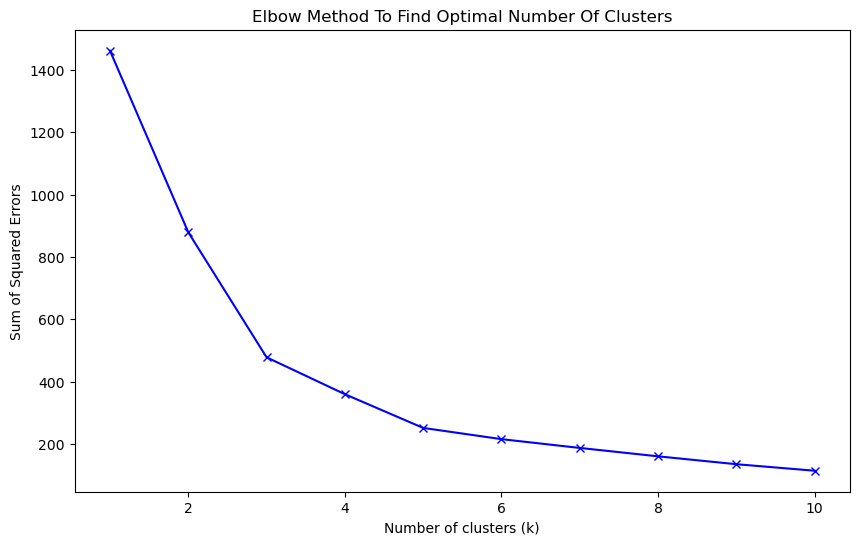

In [23]:
sse = []
k_value = range(1, 11)

for k in k_value:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(df_daily_transformed)
    sse.append(kmeans.inertia_) # inertia is SSE    

plt.figure(figsize=[10, 6])
plt.plot(k_value, sse, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors')
plt.title('Elbow Method To Find Optimal Number Of Clusters')
plt.show()

Thus, the optimal number of clusters based on the Scree Plot is **k=5**.

##### **Silhouette Metric**

As we know, The silhouette coefficient or silhouette score kmeans is a measure of how similar a data point is within-cluster (cohesion) compared to other clusters (separation).

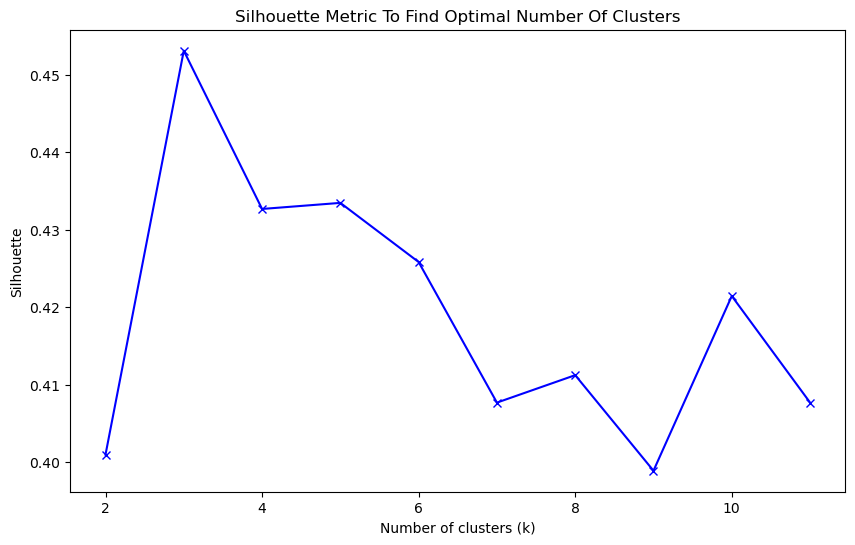

In [24]:
silhouette = []
k_value = range(2, 12) # silhouette needs at least 2 clusters

for k in k_value:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(df_daily_transformed)
    cluster_labels = kmeans.labels_
    silhouette.append(silhouette_score(df_daily_transformed, cluster_labels))

plt.figure(figsize=[10, 6])
plt.plot(k_value, silhouette, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette')
plt.title('Silhouette Metric To Find Optimal Number Of Clusters')
plt.show()

Using the Silhouette metric, the optimal value for **k** is **2**
thus, we choose **k=5** as the we deduced from the Elbow method. And we cluster based on it:

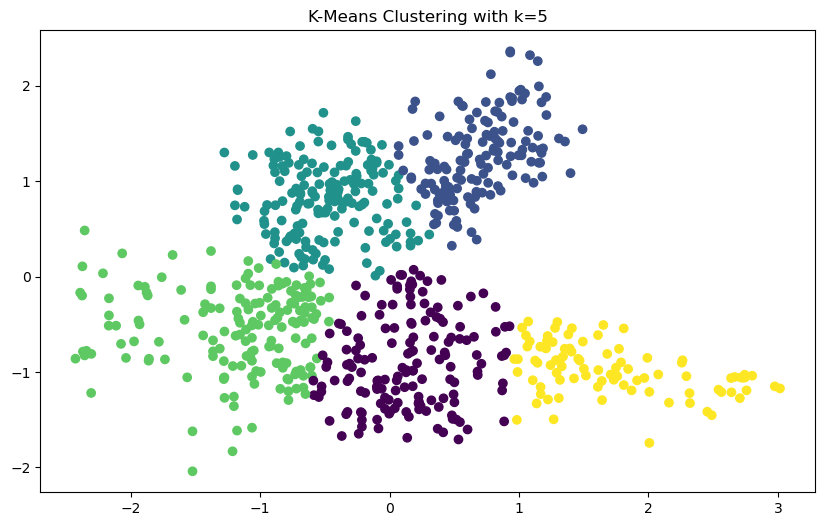

In [25]:
k = 5
kmeans = KMeans(n_clusters=k, n_init=10)
cluster = kmeans.fit(df_daily_transformed)
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

# plotting the clustering results
plt.figure(figsize=[10, 6])
plt.scatter(df_daily_transformed[:, 0], df_daily_transformed[:, 1], c=cluster_labels)
plt.title(f'K-Means Clustering with k={k}')
plt.show()

#### DBSCAN

We will now try density-based clustering with DBSCAN, directly on our daily dataframe.

<Axes: xlabel='tmp', ylabel='pma'>

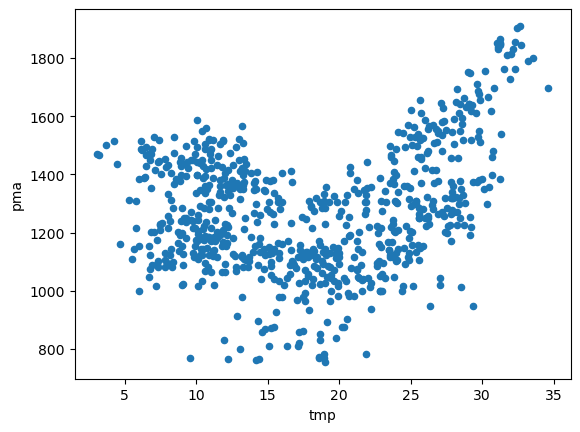

In [26]:
df_daily.plot.scatter(x='tmp', y='pma')

Yet, we ought to scale pma and tmp to be approximately on the same scale. For this, we will use **min-max scaling**.

<Axes: xlabel='tmp', ylabel='pma'>

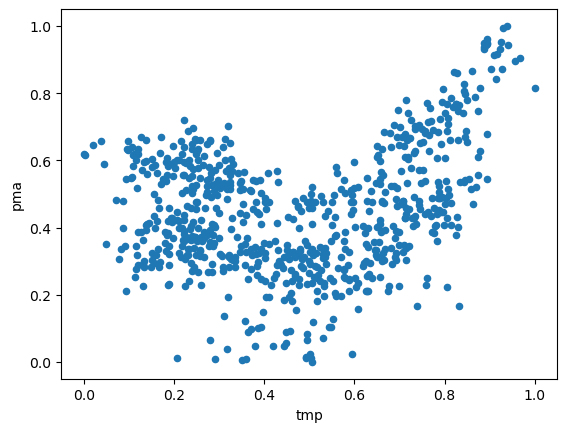

In [27]:
minmax = MinMaxScaler()

df_daily_scaled = df_daily.copy()
df_daily_scaled[['pma', 'tmp']] = minmax.fit_transform(df_daily[['pma', 'tmp']])

df_daily_scaled.plot.scatter(x='tmp', y='pma')

,pma,tmp
fullday,,
2016-01-01,1083.584698,10.793167
2016-01-02,1136.958111,11.210259
2016-01-03,1171.752876,11.308115
2016-01-04,1155.316410,14.102192
2016-01-05,1133.930420,14.428482
...,...,...
2017-12-27,1143.671565,8.259768
2017-12-28,1021.903454,9.056643
2017-12-29,1065.875303,11.061099


In [28]:
df_daily_scaled

,pma,tmp
fullday,,
2016-01-01,0.283864,0.244412
2016-01-02,0.330085,0.257643
2016-01-03,0.360217,0.260748
2016-01-04,0.345983,0.349386
2016-01-05,0.327463,0.359737
...,...,...
2017-12-27,0.335899,0.164043
2017-12-28,0.230450,0.189323
2017-12-29,0.268528,0.252912


Now, we cluster using DBSCAN:

In [ ]:
epsilon = 20 # change
min_samples = 6 # change
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan.fit(df_daily)
labels = dbscan.labels_
df_daily_scaled['cluster_id'] = labels
df_daily_scaled.cluster_id.unique()
df_daily_scaled.plot.scatter(x='tmp', y='pma', c=labels, cmap='viridis') 

As a result, we deduce having five types of days... **<!elaboration!>**  
{very high demand day, high demand day, seasonal demand day, low demand day, very low demand day}